# Download Data
Using the Kaggle API, we download the data, uncomment the following cell to do it.

In [231]:
#!kaggle competitions download -c birdclef-2025

# Libraries

In [428]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from ydata_profiling import ProfileReport
import os

# Understanding Data

La competencia **BirdCLEF+ 2025** en Kaggle se centra en la identificación de especies (aves, anfibios, mamíferos e insectos) a partir de grabaciones de audio realizadas en la Reserva Natural El Silencio, Colombia. Este desafío es esencial para mejorar el monitoreo de poblaciones animales con fines de conservación.

**Archivos proporcionados:**

- **train_audio/**: Grabaciones cortas de sonidos individuales de diversas especies, aportadas por usuarios de xeno-canto.org, iNaturalist y el Archivo Sonoro de Colombia (CSA) del Instituto Humboldt.

- **test_soundscapes/**: Aproximadamente 700 grabaciones de 1 minuto de duración en formato ogg a 32 kHz, utilizadas para evaluar las soluciones enviadas.

- **train.csv**: Metadatos asociados a las grabaciones de entrenamiento, incluyendo:
  - **primary_label**: Código de la especie.
  - **secondary_labels**: Otras especies presentes en la grabación.
  - **latitude & longitude**: Coordenadas de la grabación.
  - **author**: Usuario que proporcionó la grabación.
  - **filename**: Nombre del archivo de audio.
  - **rating**: Calidad de la grabación (1 a 5).
  - **collection**: Fuente de la grabación (XC, iNat o CSA).

- **sample_submission.csv**: Ejemplo de formato para las predicciones, donde cada fila representa un segmento de audio y las columnas corresponden a las especies objetivo.

- **taxonomy.csv**: Información sobre las especies, incluyendo ID de taxón y clase (Aves, Amphibia, Mammalia, Insecta).

- **recording_location.txt**: Detalles sobre la ubicación de grabación (Reserva Natural El Silencio).


# Unifying data and fix some problems

## train.csv and taxonomy.csv

Here I import the datasets and drop irrelevant columns for the predictions

In [251]:
# Import train.csv and taxonomy.csv as dataframe
train = pd.read_csv("birdclef-2025/train.csv")
urls= train["url"]
train = train.drop(['author', 'license',"url"],axis=1)

taxonomy = pd.read_csv("birdclef-2025/taxonomy.csv")

I create a function to separate the scientific name, which follows binomial nomenclature—meaning it first has the  `genus` with an initial capital letter and then the `species` and I create a separate column for each in the dataframe

In [252]:
def separate_name(name):
    patron = re.compile(r'\b([A-Z][a-z]+)(?:\s+([a-z]+))?\b')
    resultado = patron.search(name)
    if resultado:
        return resultado.group(1), resultado.group(2)
    else:
        return None, None

train[['genus', 'species']] = pd.DataFrame(
    [separate_name(name) for name in train['scientific_name']], 
    index=train.index
)


Since we can have the same information in a single dataframe and obtain the `inat_taxon_id`, I merge the two dataframes. Additionally, the `longitude` data is incorrect because there are positive values, which is inconsistent since Colombia is located in the quadrant where longitude is always negative.

In [253]:
taxotrain = train.merge(
    taxonomy[['primary_label', 'inat_taxon_id',"class_name"]], 
    on='primary_label',                  
    how='left'                           
)

taxotrain["longitude"] = taxotrain["longitude"].apply(lambda x: x if x < 0 else -x)


Export new dataframe.

In [254]:
taxotrain.to_csv("birdclef-2025/taxotrain.csv")

The taxotrain dataframe will be the one I use to do a first, more basic analysis.

# First basic analysis

In [288]:
# taxotrain = pd.read_csv("birdclef-2025/taxotrain.csv")

In [431]:
folder_plots = "plots" 
os.makedirs(folder_plots, exist_ok=True) 

In [243]:
profile = ProfileReport(taxotrain, explorative=True)
profile.to_file("taxotrain_automatic_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 58.26it/s]


Thanks to the profiling done by ProfileReport, we can extract the following insights:  

- The classes are highly imbalanced.  
- Latitude has 809 missing values.  
- Longitude has 809 missing values.  
- Rating has approximately 7,948 zeros (27.8%), which means that a zero indicates no rating is available
-Incomplete scientific names

---


Most of the samples in the dataset are birds, which also group most of the samples that do have a valid response for the variable type, we must develop a strategy such as data augmentation for all other classes

Classes in data are: ['Insecta' 'Amphibia' 'Mammalia' 'Aves']
Count of classes: class_name
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


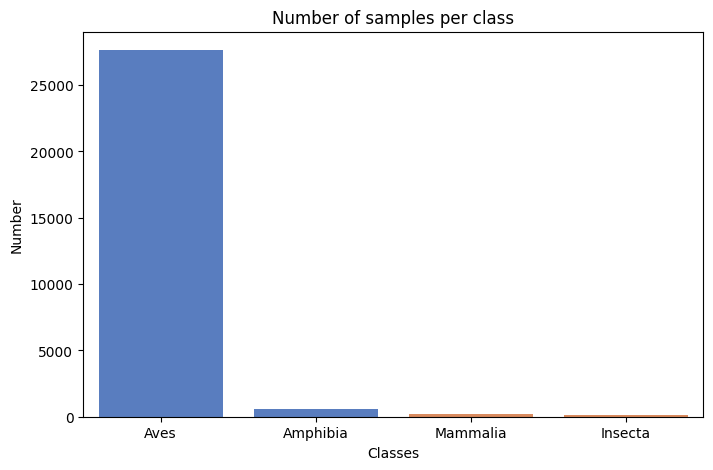

In [433]:
print(f"Classes in data are: {taxotrain["class_name"].unique()}")
print(f"Count of classes: {taxotrain["class_name"].value_counts()}")

plt.figure(figsize=(8, 5)) 
sns.barplot(x='class_name', y='count', data=pd.DataFrame(taxotrain["class_name"].value_counts()).reset_index(), palette='muted',hue=taxotrain["genus"],legend=False)

plt.xlabel("Classes")
plt.ylabel("Number")
plt.title("Number of samples per class")
plt.savefig("plots/NumberSamplesPerClasses.png", dpi=300, bbox_inches="tight")
plt.show()

In [434]:

def GenusAmountPerClass(Class,W,H):

            df = taxotrain[taxotrain["class_name"]== Class]
            print(df["genus"].value_counts())
            df = df.drop(columns=['primary_label', 'secondary_labels', 'type', 'filename', 'collection',
                'rating', 'latitude', 'longitude', 'scientific_name', 'common_name', 'inat_taxon_id', 'class_name'])
            df = pd.DataFrame(df.value_counts())
            df_reset = df.reset_index()

            genus_totals = df_reset.groupby('genus')['count'].sum().sort_values(ascending=True)

            plt.figure(figsize=(W, H))

            all_species = df_reset['species'].unique()
            colors = sns.color_palette("husl", len(all_species))
            species_colors = dict(zip(all_species, colors))

            left = np.zeros(len(genus_totals))
            y_positions = range(len(genus_totals)) 

            legend_elements = {}

            for i, genus in enumerate(genus_totals.index):
                genus_data = df_reset[df_reset['genus'] == genus].copy()
                
                genus_data = genus_data.sort_values(by='count', ascending=False)
                
                for _, row in genus_data.iterrows():
                    species = row['species']
                    count = row['count']
                    
                    bar = plt.barh(i, count, left=left[i], color=species_colors[species])
                    left[i] += count
                    

                    if species not in legend_elements:
                        legend_elements[species] = bar[0]
                        
                    if count > genus_totals.max() * 0.05:  
                        plt.text(left[i] - count/2, i, str(count), 
                                va='center', ha='center', color='white', fontweight='bold')

            plt.yticks(y_positions, genus_totals.index)


            plt.xlabel('Total number of individuals', fontsize=12)
            plt.ylabel('Genus', fontsize=12)
            plt.title('Distribution of individuals by genus and species', fontsize=14)
            plt.grid(axis='x', linestyle='--', alpha=0.7)


            for i, total in enumerate(genus_totals):
                plt.text(total + genus_totals.max() * 0.02, i, f'Total: {total}', 
                        va='center', fontweight='bold')


            plt.legend(legend_elements.values(), legend_elements.keys(), 
                    title="epithet", loc='upper right', bbox_to_anchor=(1.15, 0.8))

            plt.tight_layout()
            plt.savefig("plots/"+Class+"DistributionByEpithet.png", dpi=300, bbox_inches="tight")
            plt.show()
            return df

genus
Gryllidae          33
Cicadidae          30
Tettigoniidae      20
Copris             17
Copiphora           8
Docidocercus        7
Daedadelus          6
Neoconocephalus     5
Subria              5
Panoploscelis       5
Oxyprora            4
Eschatoceras        4
Typophyllum         4
Cocconotus          3
Ragoniella          2
Orophus             2
Name: count, dtype: int64


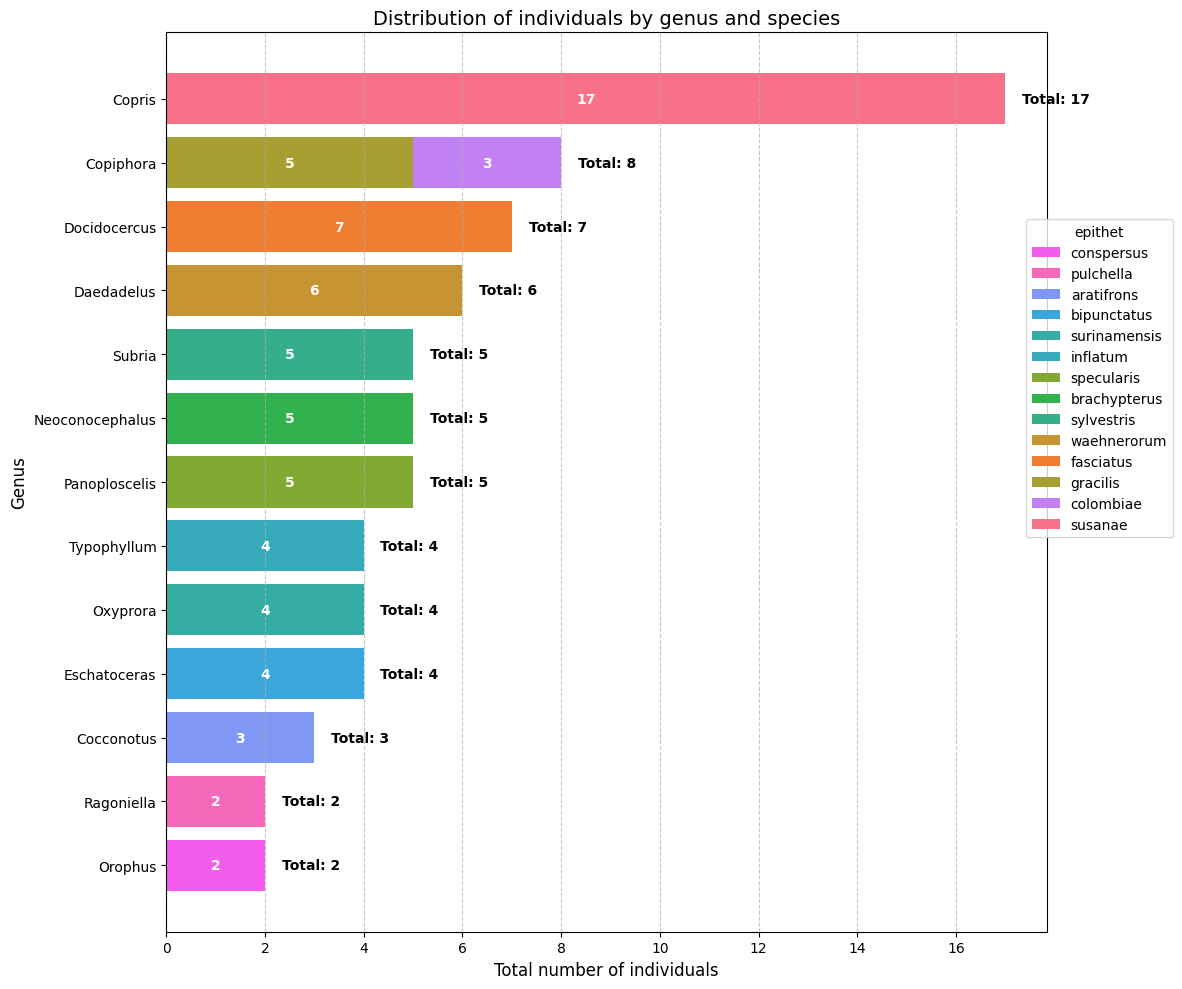

,,count
genus,species,
Copris,susanae,17
Docidocercus,fasciatus,7
Daedadelus,waehnerorum,6
Copiphora,gracilis,5
Panoploscelis,specularis,5
Neoconocephalus,brachypterus,5
Subria,sylvestris,5
Oxyprora,surinamensis,4
Typophyllum,inflatum,4


In [440]:
# GenusAmountPerClass("Aves",12,40)
# GenusAmountPerClass("Mammalia",12,7)
# GenusAmountPerClass("Amphibia",12,10)
GenusAmountPerClass("Insecta",12,10) 

# Insecta is special because it is the only group where species data is missing.

---

- Some scientific names are incomplete, with the genus present but **no assigned species**, exactly `83` all of them corresponding to **insects**.

In [239]:
taxotrain[taxotrain["species"].isna()]

,primary_label,secondary_labels,type,filename,collection,rating,latitude,longitude,scientific_name,common_name,genus,species,inat_taxon_id,class_name
458,48124,[''],[''],48124/CSA03598.ogg,CSA,0.0,5.6521,-73.5077,Tettigoniidae,Katydids,Tettigoniidae,None,48124,Insecta
459,48124,[''],[''],48124/CSA18785.ogg,CSA,0.0,5.7892,-73.5504,Tettigoniidae,Katydids,Tettigoniidae,None,48124,Insecta
460,48124,[''],[''],48124/CSA18795.ogg,CSA,0.0,5.7892,-73.5504,Tettigoniidae,Katydids,Tettigoniidae,None,48124,Insecta
461,48124,[''],[''],48124/CSA18798.ogg,CSA,0.0,5.7892,-73.5504,Tettigoniidae,Katydids,Tettigoniidae,None,48124,Insecta
462,48124,[''],[''],48124/CSA34485.ogg,CSA,0.0,3.5732,-76.5809,Tettigoniidae,Katydids,Tettigoniidae,None,48124,Insecta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,52884,[''],[''],52884/CSA35533.ogg,CSA,0.0,3.5637,-76.6194,Gryllidae,True Crickets,Gryllidae,None,52884,Insecta
601,52884,[''],[''],52884/CSA35537.ogg,CSA,0.0,3.5264,-76.7371,Gryllidae,True Crickets,Gryllidae,None,52884,Insecta
602,52884,[''],[''],52884/CSA35592.ogg,CSA,0.0,4.0058,-69.8986,Gryllidae,True Crickets,Gryllidae,None,52884,Insecta
603,52884,[''],[''],52884/CSA36342.ogg,CSA,0.0,7.3791,-73.7313,Gryllidae,True Crickets,Gryllidae,None,52884,Insecta


**After analyzing the class imbalances by genus and specific epithet, we now need to examine where the missing latitude and longitude values are concentrated, as well as where the 0s in rating are clustered to identify areas without ratings**